## Autodiff with a Linear Regression example

So far, we've seen all the fine  Jax transformations. Now let's see how we can apply them. In this example, I'm going to use a very simple linear regression model and estimate the parameters using gradient descent (which in turn requires finding gradients).

But first, let's complete the ritual of creating keys for the PRNG. (Seems kinda annoying that you've to do this every time but that's how Jax is, sadly.)

In [1]:
import jax
import jax.numpy as jnp

masterkey = jax.random.key(0)
masterkey, *subkeys = jax.random.split(masterkey, 10)

## Function to generate data

The function basically is:

$$
f(x) = 4x + 3
$$

In [2]:
f = lambda x: 4 * x + 3
f(1)

7

The function is defined, now to get some inputs for the function to generate the outputs.

In [3]:
xs = jax.random.normal(subkeys[0], shape=(1000, ))
ys = f(xs)

If you've your doubts over f being linear, well, there's always matplotlib!

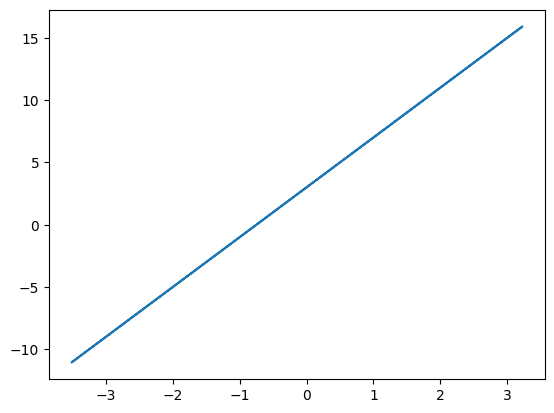

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xs, ys)

So, as of this notebook cell, we've data for regression and we've the PRNG keys for Jax. What's next then? THE MODEL!

## Model
### Model definition

The python function should be pretty self explanatory. We pass in the parameters and the input array and the function will predict some output based on the given parameters. On academic terms, this function serves as the "forward" pass.

In [5]:
@jax.jit
def lin_reg_model(params, x):
    w, b = params
    
    y_pred = w * x + b
    return y_pred

### Initial parameters

Okay, so the model has been defined, it takes in parameters, churns out some output, all good. But where are the params going to come from? We already have x. 

(Paramters initialisation, anybody? To keep things simple, I'm just initialising them from a normal distribution. Sure there are well established ways of initialising paramters but we're not writing this model to win any Kaggle competitions.)

In [6]:
def init_params():
    return jax.random.normal(subkeys[1], shape=(2, ))

params = init_params()
params

DeviceArray([ 0.97020763, -0.12123348], dtype=float32)

### Error / Objective / Loss

To be honest, academicians need to sit together and fix a single name for the same thing so people get less confused. Just get your thing together people! Anyways, so a error / loss / ........... just say loss function, we have to find one and define it. 

[Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) is a pretty simple 
loss function for discrete estimation tasks such as linear regression. You can read more [here](https://en.wikipedia.org/wiki/Ordinary_least_squares).

In [7]:
# jit, because speed
@jax.jit
def compute_loss(params, x, y):
    y_pred = lin_reg_model(params, x)
    
    # mse error
    error = jnp.mean((y - y_pred) ** 2)
    
    return error

# test
compute_loss(params, xs, ys)

DeviceArray(20.059916, dtype=float32)

## Gradient Descent

If you're already lost in the middle of all the text in the notebook, we have to update the parameters iteratively. 

So to update using gradient descent, we need the gradients. `jax.grad` will give us the gradients, but I also want to keep track of the loss values for each iteration. Does jax have anything for this? Yes. `jax.value_and_grad`. 

So just to recall, a gradient descent update roughly looks like this in terms of pseudocode:
```python
params = params - learning_rate * gradients
```

This can be done in two ways in jax. Either via using `tree_map` or just simply like the pseudocode above. I've initialised the parameters as an array. What if you've a dictionary for params? In that case, jax forbids using the regular pythonic way to update dict values recommends using `tree_map`.

In [8]:
# keeping the learning rate as 0.01 here. feel free to experiment with other values

@jax.jit
def update(params, x, y, lr=0.01): 
    # get loss value and also gradients
    values, grads = jax.value_and_grad(compute_loss)(params, x, y)
    
    updated_params = params - lr * grads
    # alternative
    # updated_params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

    return values, updated_params

## Train

In [9]:
epochs = 100

losses = list() # keep a list to plot later


for e in range(epochs):
    values, params = update(params, xs, ys)
    
    # append the loss
    losses.append(values)

Let's check on the updated params. They should be as close as possible to 4 and 3 (compare with the data generation function).

In [10]:
params

DeviceArray([3.679284 , 2.5969446], dtype=float32)

Looks quite close. How about the loss values though? Did the overall loss decrease well over the iterations (epochs)?

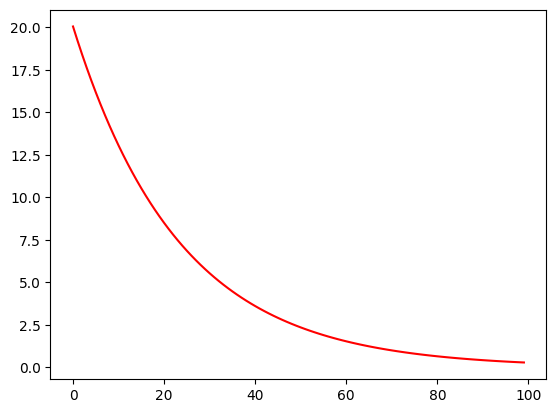

In [11]:
plt.plot(jnp.arange(epochs), losses, c="r")

## Comparing the actual and predicted function

We have the estimated parameters and now can use these to generate outputs using our linear regression model. (Estimating parameters is basically estimating a function). However one question lingers, how much of a deviation does our predicted function/model/parameters show?

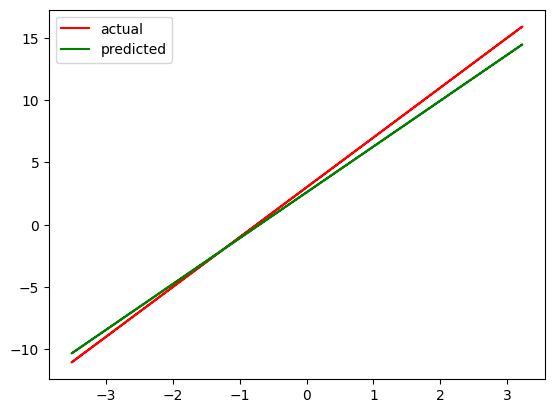

In [12]:
plt.plot(xs, ys, c="r", label="actual")
plt.plot(xs, lin_reg_model(params, xs), c="g", label="predicted")
plt.legend()

You're pretty good - [Revolver Ocelote](https://youtu.be/8xVfjkb-xVs)